## Poisson Distribution
---

The p.m.f. of a <font color=red>Poisson distribution</font> is

\begin{align*}
 p(x|\lambda) &= \frac{\lambda^x e^{-\lambda}}{x!},\quad x=0,1,2,\dots,\ \lambda>0, \\
 \mathrm{E}[X] &= \mathrm{Var}[X] = \lambda.
\end{align*}

We use a gamma distribution

$$
 \lambda\sim\mathrm{Gamma}(\alpha_0,\beta_0),
$$

as the prior distribution of $\lambda$. This is the natural conjugate prior distribution.

## Gamma Distribution
---

The p.d.f. of a <font color=red>gamma distribution</font> $\mathrm{Gamma}(\alpha,\beta)$ is given by

\begin{equation*}
 p(x|\alpha,\beta)
 = \frac{\beta^\alpha}{\Gamma(\alpha)}x^{\alpha-1}e^{-\beta x}
 \quad x>0,\ \alpha>0,\ \beta>0,
\end{equation*}

where $\Gamma(\cdot)$ is the gamma function:

\begin{equation*}
 \Gamma(x) = \int_0^\infty z^{x-1}e^{-z}dz.
\end{equation*}

In other fields, the gamma distribution is defined as

\begin{equation*}
 p(x|\alpha,\theta) = \frac{1}{\Gamma(\alpha)\theta^\alpha}x^{\alpha-1}e^{-\frac{x}{\theta}}.
\end{equation*}

$\alpha$ is called the shape parameter while $\theta$ is called the scale parameter.

In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats as st
from IPython.display import display

The following cell creates graphs of the Poisson p.f.'s and the gamma p.d.f.'s.

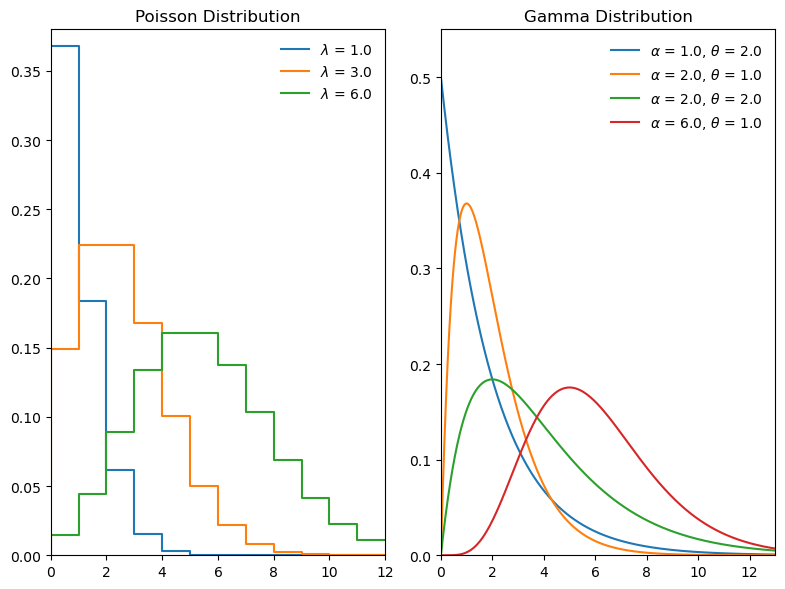

In [2]:
value_l = np.array([1.0, 3.0, 6.0])
value_a = np.array([1.0, 2.0, 2.0, 6.0])
value_t = np.array([2.0, 1.0, 2.0, 1.0])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
# Poisson  distributiona
x1 = np.linspace(0, 12, 13)
for index in range(value_l.size):
    l_i = value_l[index]
    plot_label = f'$\\lambda$ = {l_i:3.1f}'
    ax[0].step(x1, st.poisson.pmf(x1, l_i), label=plot_label)
ax[0].set_title('Poisson Distribution')
ax[0].set_xlim((0, 12))
ax[0].set_ylim((0, 0.38))
ax[0].legend(frameon=False)
# gamma distribution
x2 = np.linspace(0, 13, 1001)
for index in range(value_a.size):
    a_i = value_a[index]
    t_i = value_t[index]
    plot_label = f'$\\alpha$ = {a_i:3.1f}, $\\theta$ = {t_i:3.1f}'
    ax[1].plot(x2, st.gamma.pdf(x2, a_i, scale=t_i), label=plot_label)
ax[1].set_title('Gamma Distribution')
ax[1].set_xlim((0, 13))
ax[1].set_ylim((0, 0.55))
ax[1].legend(frameon=False)
plt.tight_layout()
plt.show()

## Likelihood
---

The likelihood of $\lambda$ given $D=(x_1,\dots,x_n)$ is

\begin{align*}
 p(D|\lambda) &= \prod_{i=1}^n p(x_i|\lambda) \\
 &= \prod_{i=1}^n \frac{\lambda^{x_i} e^{-\lambda}}{x_i!}
 = \frac{\lambda^{\sum_{i=1}^n x_i}e^{-n\lambda}}{\prod_{i=1}^n x_i!}, \\
 &= \frac{\lambda^{y}e^{-n\lambda}}{\prod_{i=1}^n x_i!},\quad
 y = \sum_{i=1}^n x_i.
\end{align*}

## Derivation of the Posterior Distribution of $\lambda$
---

Applying Bayes' theorem, we have

\begin{align*}
 p(\lambda|D) &\propto p(D|\lambda)p(\lambda) \\
 &\propto \lambda^{y}e^{-n\lambda}\times\lambda^{\alpha_0-1}e^{-\beta_0 \lambda} \\
 &\propto \lambda^{y+\alpha_0-1}e^{-(n+\beta_0)\lambda} \\
 &\propto \lambda^{\alpha_{\star}-1}e^{-\beta_{\star}\lambda} \\
 \alpha_{\star} &= y + \alpha_0,\quad \beta_{\star} = n + \beta_0.
\end{align*}

This is the gamma distribution $\mathrm{Gamma}(\alpha_{\star},\beta_{\star})$.

### HPDI of the gamma distribution

In [3]:
def gamma_hpdi(prob, alpha, theta, ci0=None):
    def hpdi_conditions(v, p, a, t):
        eq1 = st.gamma.cdf(v[1], a, scale=t) - st.gamma.cdf(v[0], a, scale=t) - p
        eq2 = st.gamma.pdf(v[1], a, scale=t) - st.gamma.pdf(v[0], a, scale=t)
        return np.hstack((eq1, eq2))
    if not ci0:
        ci0 = st.gamma.interval(prob, alpha, scale=theta)
    return opt.root(hpdi_conditions, ci0, args=(prob, alpha, theta)).x

### Posterior statsistics of $\lambda$

In [4]:
def poisson_stats(data, hyper_param, prob=0.95):
    a0 = hyper_param['a0']
    b0 = hyper_param['b0']
    n = data.size
    a_star = data.sum() + a0
    b_star = n + b0
    theta_star = 1.0 / b_star
    mean_lam = st.gamma.mean(a_star, scale=theta_star)
    median_lam = st.gamma.median(a_star, scale=theta_star)
    mode_lam = (a_star - 1.0) * theta_star
    sd_lam = st.gamma.std(a_star, scale=theta_star)
    ci_lam = st.gamma.interval(prob, a_star, scale=theta_star)
    hpdi_lam = gamma_hpdi(prob, a_star, theta_star)
    stats = np.hstack((mean_lam, median_lam, mode_lam, sd_lam, ci_lam, hpdi_lam)).reshape((1, 8))
    lower = 0.5 * (1.0 - prob) * 100.0
    upper = 0.5 * (1.0 + prob) * 100.0
    stats_string = ['mean', 'median', 'mode', 'sd',
                    f'ci ({lower:4.1f}%)', f'ci ({upper:4.1f}%)',
                    f'hpdi ({lower:4.1f}%)', f'hpdi ({upper:4.1f}%)']
    param_string = ['$\\lambda$']
    return pd.DataFrame(stats, index=param_string, columns=stats_string)

### Plotting the posterior distribution of $\lambda$

In [5]:
def interactive_poisson_posterior_plot(data, hyper_param, bounds):
    a_slider = widgets.FloatLogSlider(min=-2.0, max=2.0, step=0.1, value=hyper_param['a0'], description='$\\alpha_{0}$:')
    b_slider = widgets.FloatLogSlider(min=-2.0, max=2.0, step=0.1, value=hyper_param['b0'], description='$\\beta_{0}$:')
    l = np.linspace(bounds[0], bounds[1], 1001)

    def poisson_posterior_plot(a0, b0):
        y = np.sum(data)
        a_star = y + a0
        b_star = data.size + b0
        prior_pdf = st.gamma.pdf(l, a0, scale=1.0/b0)
        posterior_pdf = st.gamma.pdf(l, a_star, scale=1.0/b_star)
        plt.figure(figsize=(8, 6))
        plt.plot(l, prior_pdf, label=f'Prior: Gamma({a0:.2f}, {b0:.2f})')
        plt.plot(l, posterior_pdf, label=f'Posterior: Gamma({a_star:.2f}, {b_star:.2f})')
        plt.xlabel('$\\lambda$')
        plt.ylabel('Probability Density')
        plt.title('Posterior Distribution for Poisson Distribution')
        plt.xlim(bounds)
        plt.ylim(0.0, 1.1 * np.max(posterior_pdf) if np.max(posterior_pdf) > 0 else 1.0)
        plt.legend(loc='best')
        plt.show()

    return widgets.interactive(poisson_posterior_plot, a0=a_slider, b0=b_slider)

## Application 1: Simulated Data
---

We use artificial data generated from the Poisson distribution:

$$
 x_1,\dots,x_{50} \sim \mathrm{Poisson}(3).
$$

The prior distribution of $\lambda$ is $\mathrm{Gamma}(1,1)$, which is equivalent to the exponential distribution:

$$
 p(\lambda) = e^{-\lambda},\quad \lambda > 0.
$$


In [6]:
rng = np.random.default_rng(seed=99)
lam, n = 3.0, 50
data = rng.poisson(lam, size=n)
hyper_param = dict(
    a0 = 1.0,
    b0 = 1.0
)
results = poisson_stats(data, hyper_param)
display(results)

,mean,median,mode,sd,ci ( 2.5%),ci (97.5%),hpdi ( 2.5%),hpdi (97.5%)
$\lambda$,3.352941,3.346407,3.333333,0.256406,2.869216,3.873794,2.856824,3.860094


In [7]:
interactive_poisson_posterior_plot(data, hyper_param, (0.0, 6.0))

interactive(children=(FloatLogSlider(value=1.0, description='$\\alpha_{0}$:', max=2.0, min=-2.0), FloatLogSlid…

## Application 2: Prussian Army Horse Kick Data
---

### Variables:

+ y - a numeric vector, count of deaths
+ year - a numeric vector, 18XX, year of observation
+ corp - a factor, corp of Prussian Army generating observation

### Source:

prussian - Prussian army horse kick data

von Bortkiewicz, L. 1898. Das Gesetz der Kleinen Zahlen. Leipzig: Teubner.

https://vincentarelbundock.github.io/Rdatasets/datasets.html


In [8]:
prussian_data = pd.read_csv('prussian.csv', index_col=0)
horse_kick = prussian_data['y'].values

A NumPy function `histogram` creates (values, bins) of a histogram from the data set.

+ `hist` - frequency in each bin
+ `bins` - number of bins or a sequence of bins


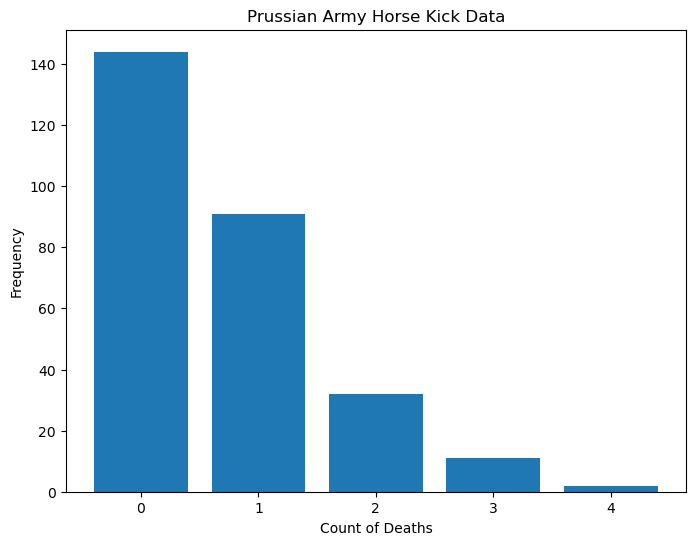

In [9]:
bin_max = np.max(horse_kick)
hist, bins = np.histogram(horse_kick, bins=np.linspace(0, bin_max+1, bin_max+2))
plt.figure(figsize=(8, 6))
plt.bar(bins[:-1], hist)
plt.title('Prussian Army Horse Kick Data')
plt.xlabel('Count of Deaths')
plt.ylabel('Frequency')
plt.show()

In [10]:
hyper_param_horse = dict(
    a0 = 1.0,
    b0 = 1.0
)
results_horse = poisson_stats(horse_kick, hyper_param_horse)
display(results_horse)

,mean,median,mode,sd,ci ( 2.5%),ci (97.5%),hpdi ( 2.5%),hpdi (97.5%)
$\lambda$,0.701068,0.699882,0.697509,0.049949,0.606582,0.802292,0.604324,0.799813


In [11]:
interactive_poisson_posterior_plot(horse_kick, hyper_param_horse, (0.0, 2.0))

interactive(children=(FloatLogSlider(value=1.0, description='$\\alpha_{0}$:', max=2.0, min=-2.0), FloatLogSlid…